In [1]:
#import libraries
from snowflake.sqlalchemy import URL
from sqlalchemy import create_engine
from datetime import datetime, timezone, timedelta
import datetime as dt
import random
import pandas as pd
import numpy as np
from snowflake.connector.pandas_tools import pd_writer
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [6]:
#Connection setup and functions
class SFConnection:
    def __init__(self):
        self.name = ''
        self.connection = ''
        self.engine = ''

    def open_conn(self):
        username = self.name + '@safeway.com'
        account_identifier = 'abs_itds_prd.west-us-2.privatelink'

        # Create an engine to connect to Snowflake
        self.engine = create_engine(
        f'snowflake://{username}@{account_identifier}/?authenticator=externalbrowser'
        )
        self.connection = self.engine.connect()
        print("Connection Opened")

    def test_conn(self):
        try:
            self.open_conn()
            results = self.connection.execute('select current_version()').fetchone()
            print("Snowflake connected to Version: {}".format(results[0]))
            return("CONNECTED")
        except Exception as e:
            print("Snowflake connection Error")
            return("ERR")

    def run_query(self, sql):
        self.connection.execute("BEGIN")
        self.connection.execute(sql)
        self.connection.execute("COMMIT")

    def query_to_df(self, sql):
        results = self.connection.execute(sql).fetchall()
        columns = results[0].keys()
        return pd.DataFrame(results, columns=columns)
        
    def close_conn(self):
        self.connection.close()
        self.engine.dispose()
        print("Connection Closed")

    def add_name(self, name):
        self.name = name
    
    #accepts a dataframe and a table name in lowercase. It is fixed currently to the FBI Schema. You only need to pass through the tablename
    #The df must be in the exact format as table
    #This will upload in chuncks of 10,000 rows to Snowflake
    #This method will replace all current values from Dataframe 
    def load_dataframe_REPLACE(self, inputdf, tablename):
        inputdf.to_sql(name=tablename.lower(), con=self.engine, if_exists='replace', index=False, chunksize=10000)
    
    #Method for inserting value without replacing to data tables 
    def load_dataframe_APPEND(self, inputdf, tablename):
        inputdf.to_sql(name=tablename.lower(), con=self.engine, if_exists='append', index=False, chunksize=10000)

In [7]:
SQL = '''--Python Program to find the combination of data for all of the differen district combinations 
select 
fiscal_year_id,
previous_store_sales_category,
mrs.DELIVERY_TYPE, 
mrs.SVCLVL_TYPE,
--mrs.DIVISION,
mrs.URBANICITY,
CASE WHEN FRST_TXN_SAVE20_PROMO_CODE_FLAG > 0 or FRST_TXN_SAVE30_PROMO_CODE_FLAG > 0 OR CYBER_CODE > 0 THEN 'USED PROMO CODE' else 'DID NOT USE PROMO CODE' end as Promo_usage,
count(distinct household_id) as Total_Households,
count (distinct case when repeat_30_days_ecomm > 0 then household_id end) as Repeat_30_day,
count (distinct case when repeat_30_days_ecomm > 0 then household_id end) / count(distinct household_id) AS RETENTION_30_DAY,
count (distinct case when repeat_60_days_ecomm > 0 then household_id end) as Repeat_60_day,
count (distinct case when repeat_60_days_ecomm > 0 then household_id end) / count(distinct household_id) AS RETENTION_60_DAY
from "EDM_BIZOPS_PRD"."FBI"."ESA_MIX_RATE_SEGMENTATION" mrs
left join "EDM_BIZOPS_PRD"."FBI"."ESA_HOLISTIC_SCORECARD_TXN_CUSTOMER_SEGMENT" cs
on mrs.txn_id = cs.txn_id
WHERE 
cs.segment_1 IN ('BNC TO ACI', 'BNC TO ECOMM')
AND FISCAL_QUARTER_ID = '202304'
AND mrs.DIVISION = 'JEWEL OSCO'
group by 
fiscal_year_id,
previous_store_sales_category,
mrs.DELIVERY_TYPE, 
mrs.SVCLVL_TYPE,
--mrs.DIVISION,
mrs.URBANICITY,
Promo_usage
'''


#Connection String Created and Query Pulled
conn = SFConnection()
conn.add_name('NACKE08') #Change to Current User LDAP
conn.test_conn()
dfRESULTS = conn.query_to_df(SQL)
conn.close_conn()

Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...
Connection Opened
Snowflake connected to Version: 8.14.2
Connection Closed


In [11]:

df_categorize_variables = list(['fiscal_year_id', 'previous_store_sales_category', 'delivery_type',
    'svclvl_type', 'urbanicity', 'promo_usage'])
    #dfData.replace(r'^\s*$', np.nan, regex=True) #replace whitespace
for item_name in df_categorize_variables:
    dfRESULTS[item_name] = pd.factorize(dfRESULTS[item_name])[0]

In [12]:
dfRESULTS.columns

Index(['fiscal_year_id', 'previous_store_sales_category', 'delivery_type',
       'svclvl_type', 'urbanicity', 'promo_usage', 'total_households',
       'repeat_30_day', 'retention_30_day', 'repeat_60_day',
       'retention_60_day'],
      dtype='object')

<AxesSubplot:>

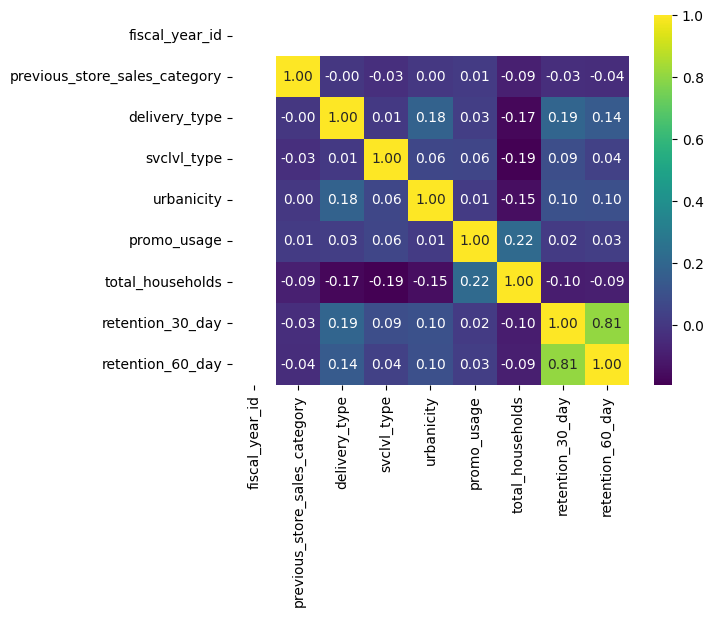

In [13]:
df_corr = dfRESULTS[['fiscal_year_id', 'previous_store_sales_category', 'delivery_type',
       'svclvl_type', 'urbanicity', 'promo_usage', 'total_households', 'retention_30_day', 'retention_60_day']].corr()

df_corr.head()

#<0.25 = No Relationship
#0.25-0.50 = Weak Relationship
#0.5- 0.75 = Moderate Relationship
#0.75-1.0 = Strong Relationship
sns.heatmap(df_corr, annot=True, cmap='viridis', fmt= '0.2f')